### Racedemia

1. Reward Function
- progress reward 
    - 챠량의 위치와 수직인 center point를 기준으로 곡선 이동량을 계산함 
        - 이게 결국에는 curvilinear coordinate으로 계산한 `e_theta`와 동일하다.
- contact penalty
    - 추가적으로 트랙의 벽면과 닿았을 때의 penalty를 줌
        - $c_{w}$를 penalty에 대한 가중치로 두고, speed를 곱해서 progress reward에서 뺀다.
        - 이렇게 penalty 값이 고정되지 않아야만 계속 벽면에 멈춰 있거나 full brake를 밟는 일이 없다.


- $r_{t}$ = $r^{prog}_{t}$ - $c_{w}$ $||v_{t}^{2}||$


2. Observation State Space
- velocity ($v_{x}$, $v_{y}$)
- acceleration ($a_{x}$, $a_{y}$)
- look-ahead curvature ($N$개의 전방의 point들에 대해서)
- $e_{phi}$
- $e_{c}$
- lidar length (전방 기준으로 좌/우 90도씩 트랙의 경계까지의 거리 계산)

In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import os, sys
sys.path.append(r'C:\Users\7459985\Desktop\2025\RDDS\001_code\meow_racer\step_1_2_rl_adv\environment'.replace('\\', '/'))
sys.path.append('..')
from track import dummy_nam_gen, dummy_rand_gen, dummy_bezier_gen
from vehicle.tools import dist_to_center, dist_to_center_simple
from vehicle import dummy_racecar
from vehicle.tools import sin_simulation
from observation import Observation_Lookahead_State
dummy_nam_gen._reset()
dummy_nam_gen._generate()
nam_track_dict = dummy_nam_gen._calculate_track_dict()

# dummy_bezier_gen._reset()
# dummy_bezier_gen._generate()
# bezier_track_dict = dummy_bezier_gen._calculate_track_dict()


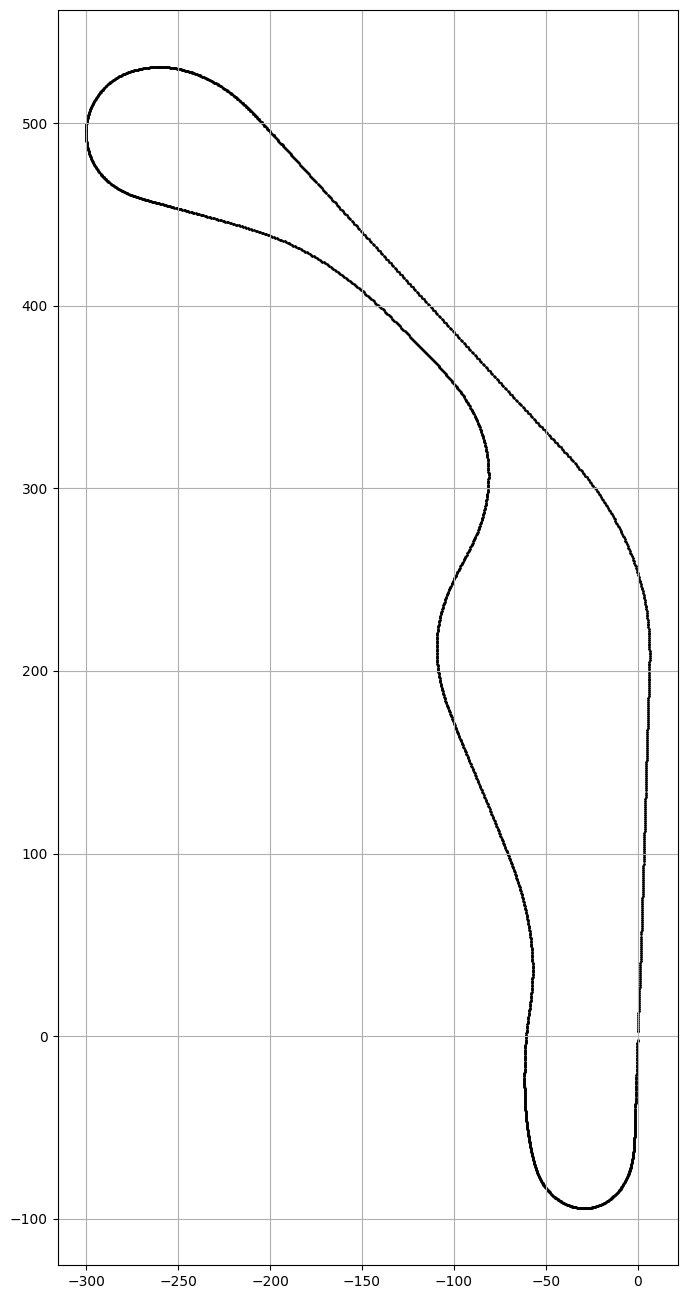

In [11]:
mx, Mx = min(nam_track_dict['x']), max(nam_track_dict['x'])
my, My = min(nam_track_dict['y']), max(nam_track_dict['y'])
dx, dy = Mx-mx, My-my
col = 8 * (dy / dx)
fig, ax = plt.subplots(figsize=(8, col))
for i, (x, y) in enumerate(zip(nam_track_dict['x'], nam_track_dict['y'])):
    plt.scatter(x, y, s=1, c='k')
    
plt.grid(True)

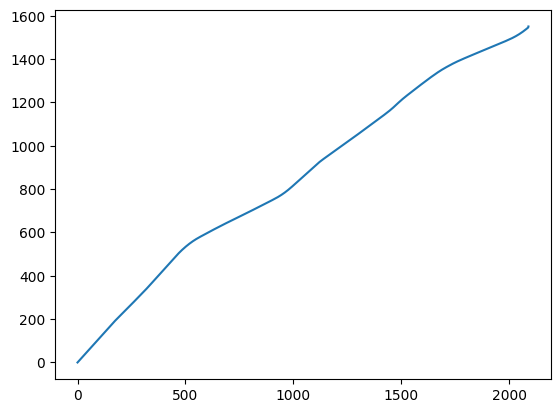

In [17]:
plt.plot(nam_track_dict['theta'])

In [16]:
import numpy as np
# car_x, car_y = -192.86213995889324 ,487.4035148118589 #-190, 490
car_x, car_y = nam_track_dict['x'][0]-0.1, nam_track_dict['y'][0]-0.1
initial_guess = nam_track_dict['theta'][np.argmin((nam_track_dict['x']- car_x)**2 + (nam_track_dict['y'] - car_y)**2)]
if isinstance(initial_guess, int):
    initial_guess = nam_track_dict[initial_guess]
# initial_guess = 0
close_car_theta = minimize(
            lambda x: dist_to_center(dummy_racecar.theta_center_spline,
                                     x[0], car_x, car_y),
            [initial_guess]
        ).x[0]

close_car_theta_simple = minimize(
            lambda x: dist_to_center_simple(dummy_racecar.theta_center_spline,
                                     x[0], car_x, car_y),
            [initial_guess]
        ).x[0]
        
print(close_car_theta)
ref_x, ref_y = dummy_racecar.theta_center_spline(close_car_theta)
print(ref_x, ref_y)

print(close_car_theta_simple)
ref_x, ref_y = dummy_racecar.theta_center_spline(close_car_theta_simple)
print(ref_x, ref_y)


print(car_x, car_y)

-0.10321239422371424
0.08574846367048779 2.4585611409031602
-0.10321404178277838
0.08574840901127223 2.4585594934339325
-0.010806199336000008 2.4617628580999997


In [23]:
import numpy as np
a = np.random.random(1)
print(a)

[0.1313155]


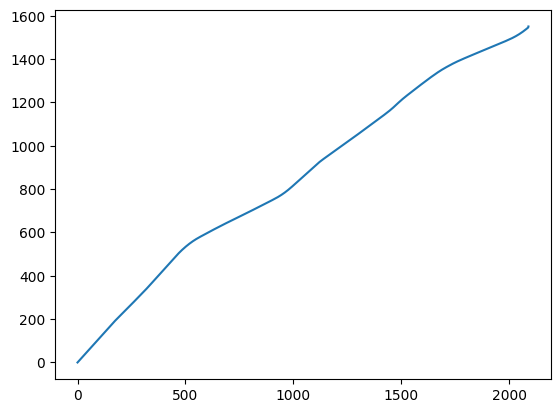

In [22]:
plt.plot(nam_track_dict['theta'])

In [4]:
dummy_racecar._reset(track_dict=nam_track_dict)
# dummy_racecar._reset(track_dict=bezier_track_dict)
lookahead_state = Observation_Lookahead_State(car_obj=dummy_racecar,
                                              lookahead_time=6,
                                              num_states=30,
                                              track_dict = nam_track_dict)

dummy_racecar = sin_simulation(
    num_step=300, freq=0.2, dt=0.1, max_deg=10, race_car=dummy_racecar
)
traj_arr = dummy_racecar.bicycle_model.car_traj_arr

In [4]:
dummy_racecar.bicycle_model.dCar_x, dummy_racecar.bicycle_model.dCar_y

(np.float64(8.423842586063534), np.float64(7.272048426527756))

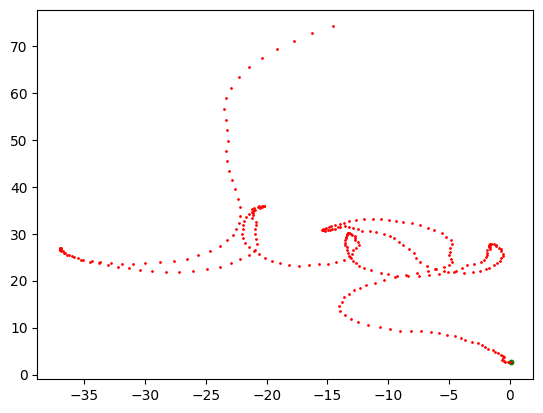

In [5]:
for i, (x, y, _, _, _) in enumerate(traj_arr):
    if i == 0:
        plt.scatter(x, y, s=10, c='g')
    else:
        plt.scatter(x,y, s=1, c='r')

In [9]:
center_spline = dummy_racecar.theta_center_spline
kappa_spline = dummy_racecar.kappa_spline

fx, fy, theta_range, lookahead_K_arr = lookahead_state._lookahead_curvature(
    theta_center_spline=center_spline,
    kappa_spline=kappa_spline, debug=True
)

# fx, fy, theta_range, lookahead_K_arr = dummy_racecar.bicycle_model.lookahead_curvature(time=6,
#                                   num_states=50,
#                                   theta_center_spline=center_spline,
#                                   kappa_spline=kappa_spline,
#                                   debug=True)

In [10]:
fx, fy, dummy_racecar.bicycle_model.car_x, dummy_racecar.bicycle_model.car_y

(np.float64(104.15116053738251),
 np.float64(24.51350366785598),
 np.float64(112.83753802970888),
 np.float64(23.527704613788835))

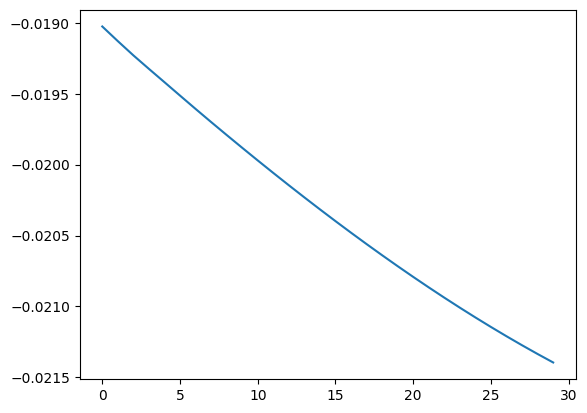

In [11]:
plt.plot(lookahead_K_arr)

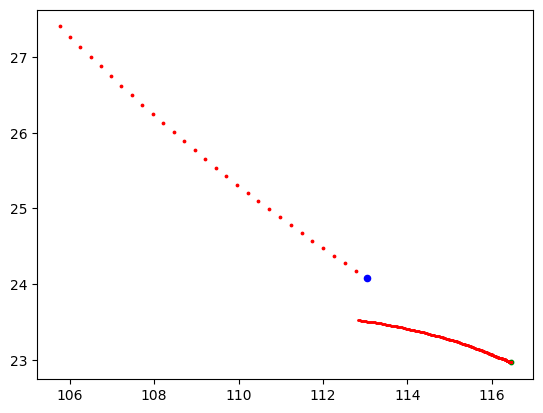

In [12]:
for i, (x, y, _, _, _) in enumerate(traj_arr):
    if i == 0:
        plt.scatter(x, y, s=10, c='g')
    else:
        plt.scatter(x,y, s=1, c='r')
        
for i, theta in enumerate(theta_range):
    xx, yy = center_spline(theta)
    if i == 0:
        plt.scatter(xx, yy, s=20, c='b')
    else:
        plt.scatter(xx, yy, s=3, c='r')

In [15]:
from PIL import Image
import numpy as np

def make_gif(save_path, image_paths):
    frames = [Image.open(image) for image in image_paths]
    frame_one = frames[0]
    frame_one.save(save_path, format="GIF", append_images=frames,
        save_all=True, duration=100, loop=0)
    
def get_fig_size(X, Y):
    X, Y = np.array(X), np.array(Y)
    dX = max(X) - min(X)
    dY = max(Y) - min(Y)
    
    col = 8
    row = col * (dY / dX)
    
    return col, row # 가로, 세로 #


In [16]:
theta_range ## 반대로 이동하면 theta range가 음수가 됨 -> 왜 그런지는 잘 모르겠지만

array([ 4.23898574,  4.51440033,  4.78981492,  5.06522951,  5.34064411,
        5.6160587 ,  5.89147329,  6.16688789,  6.44230248,  6.71771707,
        6.99313167,  7.26854626,  7.54396085,  7.81937544,  8.09479004,
        8.37020463,  8.64561922,  8.92103382,  9.19644841,  9.471863  ,
        9.7472776 , 10.02269219, 10.29810678, 10.57352137, 10.84893597,
       11.12435056, 11.39976515, 11.67517975, 11.95059434, 12.22600893])

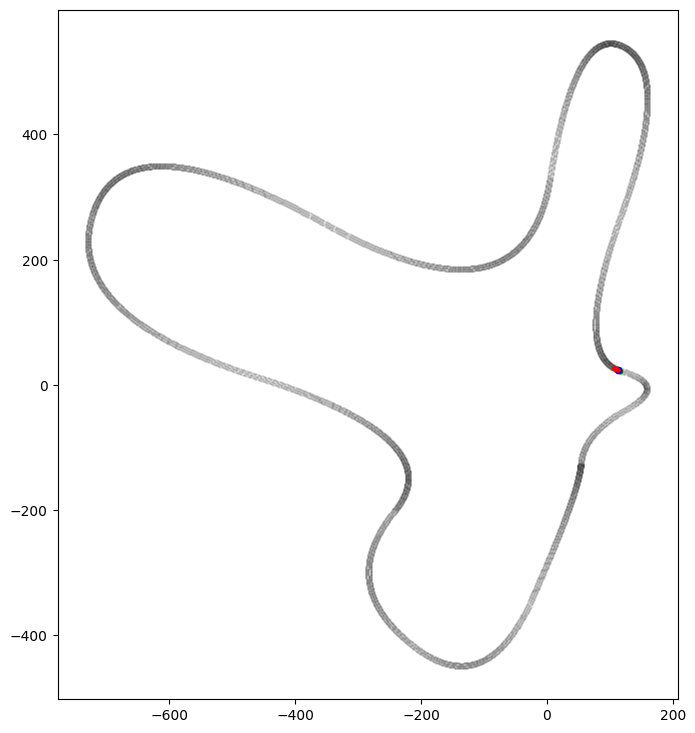

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms
import math
import numpy as np
##rotate를 할 때 +X축 방향을 바라보는 모양인것 처럼 해야 하기 때문에 
width = 1
height = 0.5

car_idx = 150

car_x, car_y, car_phi = traj_arr[car_idx][:3]

FIG_PATH = r'C:\Users\7459985\Desktop\2025\RDDS\001_code\meow_racer\step_1_rl\envs_2\debug\figures_0406'.replace('\\', '/')
# fig, ax = plt.subplots(figsize=(6, 10))
col, row = get_fig_size(bezier_track_dict['x'], bezier_track_dict['y'])
fig, ax = plt.subplots(figsize=(col, row))
for i, (x, y) in enumerate(zip(bezier_track_dict['x'], bezier_track_dict['y'])):
    plt.scatter(x, y, s=1, alpha=0.1, c='k')
    plt.scatter(bezier_track_dict['left'][i][0], bezier_track_dict['left'][i][1], c='k', s=1, alpha=0.1)
    plt.scatter(bezier_track_dict['right'][i][0], bezier_track_dict['right'][i][1], c='k', s=1, alpha=0.1)

#### plot the trajectory of the vehicle ####
for i, (x, y, _, _, _) in enumerate(traj_arr):
    if i == 0:
        plt.scatter(x, y, s=10, c='g')
    else:
        plt.scatter(x,y, s=1, c='r')

#### plot the lookahead center points of the track ####
for i, theta in enumerate(theta_range):
    xx, yy = center_spline(theta)
    if i == 0:
        plt.scatter(xx, yy, s=20, c='b')
    else:
        plt.scatter(xx, yy, s=3, c='r')
# image_paths = []
# for i in range(len(traj_arr)):
#     car_x, car_y, car_phi = traj_arr[car_idx][:3]
#     rect = patches.Rectangle((car_x-width/2, car_y-height/2), width, height, linewidth=2, facecolor='red', edgecolor='red')
#     rotate = transforms.Affine2D().rotate_deg_around(car_x, car_y, math.degrees(car_phi))
#     rect.set_transform(rotate + ax.transData)
#     p1 = ax.add_patch(rect);ax.set_aspect(True);plt.savefig(f"{FIG_PATH}/{i}.png")
#     p1.remove()
#     image_paths.append(f"{FIG_PATH}/{i}.png")

# make_gif(save_path=f"{FIG_PATH}/simulate.gif", image_paths=image_paths)
# ax.add_patch(rect);ax.set_aspect(True)

**Necessary Observation State Values**
1. Scalar progress of the car along the track (차량의 트랙을 따라 이동한 거리 - 아마 theta value일듯 - 근데 어떻게 sin, cosine으로 나타내는가?)
    - represented as sin, cosine components  
    - 현재 시점의 값만을 필요로 하는 것 같음.

2. Car's orientation with respect to the course center line (차량의 yaw angle과 트랙의 phi각과의 차이)
    -  Euler angle between the 2D vector that defines the agent's rotation in the horizontal plane and the unit tangent vector that is tangent to the center line at the projection point
    - The difference of the phi value of the closest track and the phi value of the car  

3. Car's most recent control values  
    -> Policy가 취한 action에 따라서 바뀌는 "실제 제어값"을 observation state로 넣어줌
    - steering angle
    - throttle intensity
    - brake intensity  

4. Car's velocity
    - vx vy (2,)

5. Car's angular velocity
    - omega (1,)

6. Car's acceleration
    - ax ay (2,)

7. load on each tire 
    - F_fy F_ry F_fx F_rx (4,)

8. tire-slip angles
    - alpha_f alpha_r (2,)

9. Binary value regarding the wall contact information
    - (1,)

10. Forward Vector (on fixed-body frame)
    - (num_vectors, )

11. Lookahead Curvature
    - (num_states,)
    - 일정 시간동안 현재 차량의 속도로 진행을 했을때 center line들의 곡률 정보

12. Lidar Sensor (distance measurements)
    - (num_lidar, )
    - 트랙 주변까지의 거리 

13. Lookahead Coordinates
    - (left, center, right) course points describing the course ahead on the basis of the car's velocity
    - (num_states, )
    - 일정 시간동안 현재 차량의 속도로 진행을 헀을 때 left / center / right의 좌표 정보
    

**Important Factors to Consider**
1. Car left the track 
    - COM이 트랙 밖으로 나갔을 때 (1)
    - 차량의 일부가 조금이라도 트랙 밖으로 나갔을 때 (2)
    - 차량 전체가 트랙 밖으로 나갔을 때 (3)

        - (1), (3)의 상황에 대해서는 조금이라도 밖으로 나갔을 때에 대한 binary state signal을 observation의 입력으로 추가하게 될 수 있다.
2. Car point tracker

In [15]:
curves = dummy_bezier_gen.curves

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
yaw_angle = math.radians(30) ## 흔히 아는 rotation 행렬은 반시계 방향으로 회전을 하도록 하는데, inertia frame -> body fixed frame으로 바꾸기 위해서는 
## angle에 -1을 곱해주기만 하면 상당히 간단하게 해결할 수 있다. 
x, y= 2,2
R = np.array([
            [np.cos(-yaw_angle), -np.sin(-yaw_angle)],
            [np.sin(-yaw_angle), np.cos(-yaw_angle)]
        ])
rotate = R@np.array([x, y]).T

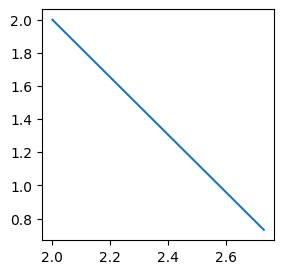

In [4]:
fig, ax = plt.subplots(figsize=(3,3))
plt.plot([x, rotate[0]], [y, rotate[1]])

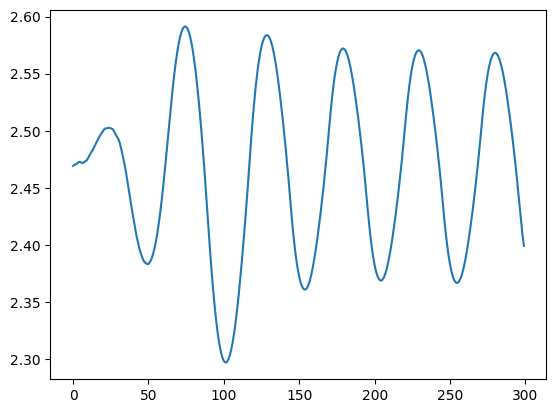

In [7]:
import numpy as np;plt.plot(np.array(traj_arr).T[2])

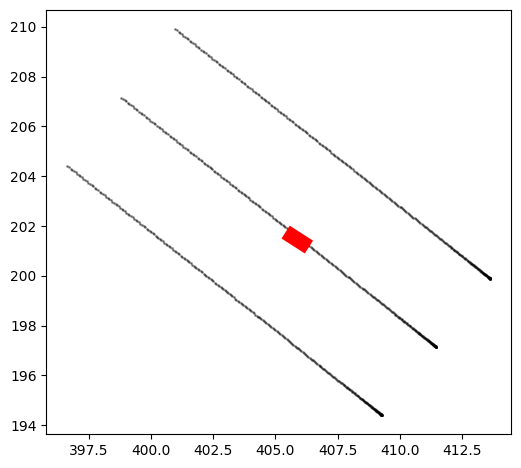

In [61]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms
import math
width = 1
height = 0.5

car_idx = 180# len(traj_arr)-1 #0 # 100
## 차량의 위치는 vehicle Center of Mass로 간주해야 함.
car_x, car_y, car_phi = traj_arr[car_idx][:3]

vis_bound_x = [40, 40]
vis_bound_y = [10, 100]
vis_bound_theta = 100

theta_spline = dummy_racecar.theta_center_spline

fig, ax = plt.subplots(figsize=(6, 10))
ref_center = dummy_racecar.bicycle_model.ref_arr_dict['center']
ref_left = dummy_racecar.bicycle_model.ref_arr_dict['left']
ref_right = dummy_racecar.bicycle_model.ref_arr_dict['right']
ref_theta = dummy_racecar.bicycle_model.ref_arr_dict['theta']

# for i, (x, y) in enumerate(zip(nam_track_dict['x'], nam_track_dict['y'])):
for i, (x, y) in enumerate(ref_center):
    if car_x - vis_bound_x[0] <= x <= car_x + vis_bound_x[1] and car_y - vis_bound_y[0] <= y <= car_y + vis_bound_y[1]:
        plt.scatter(x, y, s=1, alpha=0.4, c='k')
        plt.scatter(ref_left[i][0], ref_left[i][1], c='k', s=1, alpha=0.4)
        plt.scatter(ref_right[i][0], ref_right[i][1], c='k', s=1, alpha=0.4)


rect = patches.Rectangle((car_x-width/2, car_y-height/2), width, height, linewidth=2, facecolor='red', edgecolor='red')
rotate = transforms.Affine2D().rotate_deg_around(car_x, car_y, math.degrees(car_phi))
rect.set_transform(rotate + ax.transData)

ax.add_patch(rect)
ax.set_aspect(True) ## 이게 있어야 rectangle patch가 회전을 해도 모양이 바뀌지 않음 ##

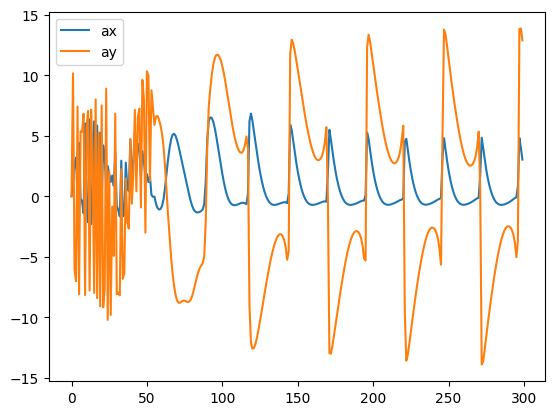

In [57]:
acc_x_arr = dummy_racecar.bicycle_model.acc_x_arr
acc_y_arr = dummy_racecar.bicycle_model.acc_y_arr
plt.plot(acc_x_arr, label='ax')
plt.plot(acc_y_arr, label='ay')
plt.legend()

# Look-Ahead Curvature

# LiDAR Sensor

**Sample Code for Bezier Curve-Line-Intersection**
```py
>>> import bezier
>>> import numpy as np
>>> nodes1 = np.asfortranarray([
...     [0.0, 0.5, 1.0],
...     [0.0, 1.0, 0.0],
... ])
>>> curve1 = bezier.Curve(nodes1, degree=2)
>>> nodes2 = np.asfortranarray([
...     [0.0  , 1.0  ],
...     [0.375, 0.375],
... ])
>>> curve2 = bezier.Curve(nodes2, degree=1)
>>> intersections = curve1.intersect(curve2)
>>> intersections
array([[0.25, 0.75],
       [0.25, 0.75]])
>>> s_vals = np.asfortranarray(intersections[0, :])
>>> curve1.evaluate_multi(s_vals)
array([[0.25 , 0.75 ],
       [0.375, 0.375]])
```

In [43]:
import bezier
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import CubicSpline


track_curves = dummy_bezier_gen.curves

def get_lidar_ray(car_x, car_y, yaw, lidar_angle, max_range:float=100.):
    angle = yaw + lidar_angle
    x1 = car_x + max_range * np.cos(angle)
    y1 = car_y + max_range * np.sin(angle)
    return (car_x, car_y), (x1, y1)

def segment_intersection(p1, p2, q1, q2):
    # p1-p2: ray, q1-q2: wall segment
    
    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    dx1 = p2[0] - p1[0]
    dy1 = p2[1] - p1[1]
    dx2 = q2[0] - q1[0]
    dy2 = q2[1] - q1[1]
    
    delta = det((dx1, dy1), (dx2, dy2))
    if delta == 0:
        return None
    
    s = det((q1[0] - p1[0], q1[1] - p1[1]), (dx2, dy2)) / delta
    t = det((q1[0] - p1[0], q1[1] - p1[1]), (dx1, dy1)) / delta
    
    if s >= 0 and 0 <= t <= 1:
        ix = p1[0] + s * dx1
        iy = p1[1] + s * dy1
        return (ix, iy)
    else:
        return None

def find_closest_intersection(car_x, car_y, yaw, lidar_angle, wall_points, max_range:float=100.):
    ray_start, ray_end = get_lidar_ray(car_x, car_y, yaw, lidar_angle, max_range)
    closest_point = None
    min_dist = float('inf')
    
    for i in range(len(wall_points)-1):
        wall_start = wall_points[i]
        wall_end = wall_points[i+1]
        intersect = segment_intersection(p1=ray_start, p2=ray_end, q1=wall_start, q2=wall_end)
        if intersect is not None:
            dist = np.linalg.norm(np.array(intersect) - np.array((car_x, car_y)))
            if dist < min_dist:
                min_dist = dist
                closest_point = intersect
    
    
    return closest_point, min_dist


In [44]:
def lidar_scan(car_x, car_y, yaw, 
               lidar_angle_min, lidar_angle_max, num_lidar,
               wall_points_arr, max_range):
    lidar_angles = np.linspace(lidar_angle_min, lidar_angle_max, num_lidar)
    results = []
    for angle in lidar_angles:
        min_dist = float('inf');min_point = None
        for i, wall_point in enumerate(wall_points_arr):
            point, distance = find_closest_intersection(car_x, car_y, yaw, angle, wall_point, max_range)
            if min_dist > distance:
                min_dist = distance
                min_point = point
        results.append({
            "angle": angle, "point": min_point, "distance": min_dist
        })
    
    return results

In [70]:
math.degrees(yaw)

137.46151498002155

In [45]:
bezier_track_dict['left'].shape

(2892, 2)

In [46]:
car_x, car_y = dummy_racecar.bicycle_model.car_x, dummy_racecar.bicycle_model.car_y
yaw = dummy_racecar.bicycle_model.car_phi
lidar_angle_min = -np.pi / 2
lidar_angle_max = np.pi / 2
num_lidar = 30


wall_points_arr = [
    np.array(bezier_track_dict['left']), np.array(bezier_track_dict['right'])
]

max_range = 100

result = lidar_scan(
    car_x=car_x,
    car_y=car_y,
    yaw=yaw,
    lidar_angle_min=lidar_angle_min,
    lidar_angle_max=lidar_angle_max,
    num_lidar=num_lidar,
    wall_points_arr=wall_points_arr,
    max_range=max_range
)

In [53]:
bezier_track_dict.keys()

dict_keys(['theta', 'phi', 'beta', 'kappa', 'x', 'y', 'vertices', 'left', 'right'])

In [62]:
def get_car_pos_nxn(X, Y, car_x, car_y, n):
    X, Y = np.array(X), np.array(Y)
    mx, Mx = min(X), max(X)
    
    if not (mx <= car_x <= Mx and my <= car_y <= My):
        return None
    
    cell_width = (Mx - mx) / n
    cell_height = (My - my) / n
    
    i = int((x - mx) / cell_width)
    j = int((y - my) / cell_height)
    
    i = min(i, n-1)
    j = min(j, n-1)
    
    cell_X = [mx + cell_width * i, mx + cell_width * (i+1)]
    cell_Y = [my + cell_width * j, my + cell_width * (j+1)]
    
    return i, j, cell_X, cell_Y


In [72]:
cell_X, cell_Y

([np.float64(371.6478958728183), np.float64(603.969335819324)],
 [np.float64(-30.76268539207763), np.float64(201.5587545544281)])

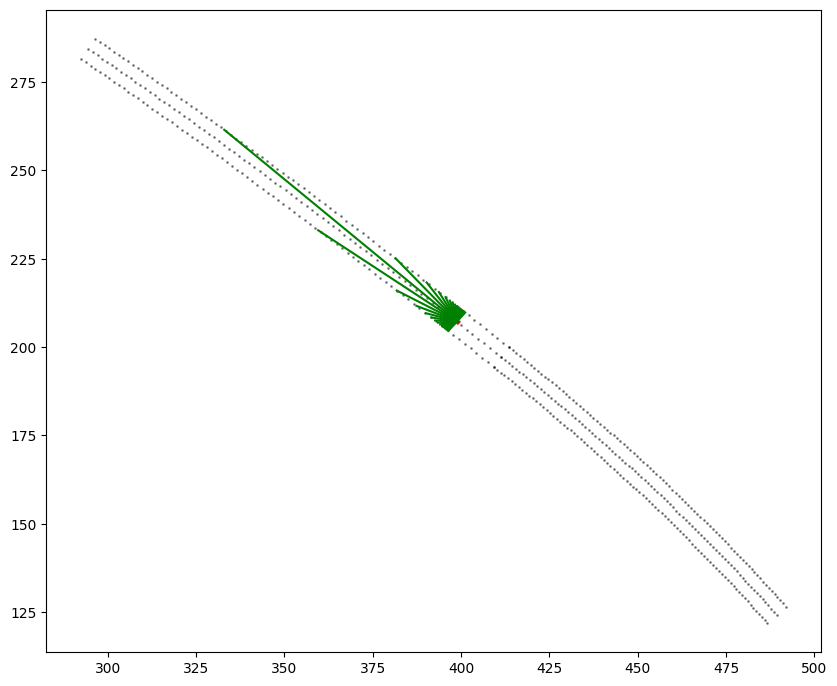

In [75]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms
import math
width = 1
height = 0.5

# car_idx = len(traj_arr)-1#  0 # 100
## 차량의 위치는 vehicle Center of Mass로 간주해야 함.
# car_x, car_y, car_phi = traj_arr[car_idx][:3]
car_x, car_y = dummy_racecar.bicycle_model.car_x, dummy_racecar.bicycle_model.car_y
car_phi = dummy_racecar.bicycle_model.car_phi
mx, Mx = min(bezier_track_dict['x']), max(bezier_track_dict['x'])
my, My = min(bezier_track_dict['y']), max(bezier_track_dict['y'])

ci, cj, cell_X, cell_Y = get_car_pos_nxn(bezier_track_dict['x'], bezier_track_dict['y'], car_x, car_y, 3)

# vis_bound_y = [40, 40]
# vis_bound_y = [10, 100]
vis_bound_theta = 100

theta_spline = dummy_racecar.theta_center_spline

fig, ax = plt.subplots(figsize=(10, 10))
ref_center = dummy_racecar.bicycle_model.ref_arr_dict['center']
ref_left = dummy_racecar.bicycle_model.ref_arr_dict['left']
ref_right = dummy_racecar.bicycle_model.ref_arr_dict['right']
ref_theta = dummy_racecar.bicycle_model.ref_arr_dict['theta']

for i, (x, y) in enumerate(zip(bezier_track_dict['x'], bezier_track_dict['y'])):
# for i, (x, y) in enumerate(ref_center):
    # if car_x - vis_bound_x[0] <= x <= car_x + vis_bound_x[1] and car_y - vis_bound_y[0] <= y <= car_y + vis_bound_y[1]:
    if cell_X[0] <= x <= cell_X[1] and cell_Y[0] <= y <= cell_Y[1]:
        plt.scatter(x, y, s=1, alpha=0.4, c='k')
        plt.scatter(bezier_track_dict['left'][i][0], bezier_track_dict['left'][i][1], c='k',s=1, alpha=0.4)
        plt.scatter(bezier_track_dict['right'][i][0], bezier_track_dict['right'][i][1], c='k',s=1, alpha=0.4)
        
        # plt.scatter(ref_left[i][0], ref_left[i][1], c='k', s=1, alpha=0.4)
        # plt.scatter(ref_right[i][0], ref_right[i][1], c='k', s=1, alpha=0.4)


rect = patches.Rectangle((car_x-width/2, car_y-height/2), width, height, linewidth=2, facecolor='red', edgecolor='red')
rotate = transforms.Affine2D().rotate_deg_around(car_x, car_y, math.degrees(car_phi))
rect.set_transform(rotate + ax.transData)

for i in range(len(result)):
    pt = result[i]['point']
    plt.plot((car_x, pt[0]), (car_y, pt[1]), c='g')
    
ax.add_patch(rect)
ax.set_aspect(True) ## 이게 있어야 rectangle patch가 회전을 해도 모양이 바뀌지 않음 ##

In [8]:
import numpy as np
main = np.array([9,10])
a = np.array([1,2,3,4,5])
main = np.hstack([main, a])
print(main)

[ 9 10  1  2  3  4  5]


In [10]:
a = np.array([
    [1,2,3,4,5,6,7,8,9],
    [-1, -2, -3, -4, -5, -6, -7, -8, -9]
])
b = a.T
print(b)

[[ 1 -1]
 [ 2 -2]
 [ 3 -3]
 [ 4 -4]
 [ 5 -5]
 [ 6 -6]
 [ 7 -7]
 [ 8 -8]
 [ 9 -9]]


In [12]:
close_car_theta = 10
close_future_theta = 10

num_states = 30
theta_range = np.linspace(close_car_theta, close_future_theta, num_states)
print(theta_range)

[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


In [11]:
b.reshape(-1)

array([ 1, -1,  2, -2,  3, -3,  4, -4,  5, -5,  6, -6,  7, -7,  8, -8,  9,
       -9])

# Forward Vector